# Data Description

**1. train.csv [파일]**
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 제품 품질 상태(Target) 
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)
- Y_Quality : 제품 품질 관련 정량적 수치
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수
- 06.13.2022~09.08.2022 DATA



**2. test.csv [파일]**
- PRODUCT_ID : 제품의 고유 ID
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수
- 09.09.2022~11.05.2022 DATA 

**3. sample_submission.csv [파일] - 제출 양식**
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 예측한 제품 품질 상태
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)

- 실제 공정 과정에서의 데이터로, 보안상의 이유로 일부 변수가 비식별화 처리 되었습니다. (X변수)
- 'LINE', 'PRODUCT_CODE'는 Train / Test 모두 동일한 종류가 존재합니다.

## DATA LEAKAGE - RULE 
1. 대표적인 Data Leakage에 해당하는 사례
    - Label Encoding 시 Test 데이터로부터 Encoder를 fit 시키는 경우
    - Scaler 사용 시 Test 데이터로부터 Scaler를 fit 시키는 경우
    Test 데이터에 대한 결측치 보간 시 Test 데이터의 통계 정보(평균, 최빈값 등)를 사용하는 경우
    - 파생변수를 생성할 시 2개 이상의 Test 데이터들의 정보를 활용할 경우
    - Test 데이터들의 이동 평균을 활용하는 경우
    - Test 데이터들을 모델 학습에 활용하는 경우 (이번 해커톤에서는 Pseudo-Labeling도 허용하지 않습니다)
    - Test 데이터에 pandas의 get_dummies() 함수를 적용하는 경우
        - (=) Test DATA로 Encoder를 fitting 한 것과 같으므로
        - ==> Encoder를 Train data로 fitting 한 후, Test data에 Transform (GOOD)  
    - Test 데이터의 index 정보 혹은 row 개수 정보를 활용하는 경우
    - Test 데이터로부터 EDA를 진행한 결과(인사이트)를 전처리, 모델 학습에 적용하는 경우
    - 이 밖의 Test 데이터들의 정보를 모델 학습에 활용하는 모든 경우


2. 대표적인 Data Leakage에 해당하지 않는 사례
    - 독립적인 샘플(행(row)) 내에서의 모든 연산 혹은 파생 변수 생성
        - 예를 들어, Test['C'] = Test['A'] + Test['B']와 같이 독립적인 샘플 내에서 A Column과 B Column을 더한 새로운 파생 변수 C Column을 생성하는 경우
    - Train 데이터의 통계 정보를 Test 데이터에 적용하여 전처리하는 경우 혹은 파생 변수를 생성하는 경우
    - Test 데이터의 결측치를 Train 데이터의 통계 정보를 바탕으로 보간하는 경우 


# MODULE IMPORT

In [1]:
!pip install tabnet 
!pip install pytorch_tabnet
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
import optuna   # auto hyper-parameter tuning  
from tqdm.notebook import tqdm

import sklearn.metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, log_loss

# Modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor   
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBRegressor
from xgboost import XGBClassifier 
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier 
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# TabNet 
from tabnet import TabNet, TabNetClassifier
from tabnet import StackedTabNetClassifier        
from pytorch_tabnet.tab_model import TabNetRegressor
# from pytorch_tabnet.tab_model import TabNetClassification
# from pytorch_tabnet.tab_model import TabNetModel
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.pretraining import TabNetPretrainer

# Oversampling
from imblearn.over_sampling import BorderlineSMOTE

# google drive mount
from google.colab import drive
drive.mount('/content/drive')

# random_state seed 37 fixed 
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37)

# warning message delete 
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)   


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0.Data Load

In [8]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
train_df = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

In [9]:
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
test_df = test_df.drop(columns=['PRODUCT_ID','TIMESTAMP'])

# 1.Pre-processing
1. Missing Values:
    - All NaN column: `fillna(0)`
    - fill grouped mean 
    - fill feature(column)'s mean 

## 1.1 EDA
1. `Y_Quality` and `X features`: 
    - NOT high correlation, yet  

In [ ]:
# random 20 features list 
Xs = train_df.iloc[:,4:].columns
null_count = train_df.isnull().sum().to_dict()
cols = pd.DataFrame({i for i in null_count if null_count[i]<250 and i in Xs})
cols_name = list(cols[0])  # not_all_NAN features name in list 

import random
a = ['Y_Quality']
for i in range(20):
    num = random.randint(1,2875)
    a.append(cols_name[i])

# heatmap: `random X features` and `Y_Quality` correlation 
# corr = train_df[a].corr()  # correlation matrix
# fig, ax = plt.subplots(figsize=(15,10))
# sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues', linewidths=2);

## 1.2 Merge & Encoding
1. Merge `LINE` & `PRODUCT_CODE` & `Y_Class`columns by JOIN function
    - set the joined column name as `line_pcode_class`
2. Label encoding 
    - encode qualitative into quantitative

In [17]:
# Merge columns 
col = ['LINE', 'PRODUCT_CODE']
train_df['line_pcode'] = train_df[col].apply(lambda row: ':'.join(row.values), axis=1)
train_df = train_df.drop(columns=['LINE', 'PRODUCT_CODE'])  
print(train_df['line_pcode'].value_counts())  

# Label Encoding 
from sklearn.preprocessing import LabelEncoder
qual_col = ['line_pcode']
for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_df[i])
    train_df[i] = le.transform(train_df[i])
print(train_df.line_pcode.unique())

KeyError: ignored

## 1.3 Missing Values
- [fill out NaN with Column's && Group's mean](https://rfriend.tistory.com/402) 

In [16]:
# ONLY 0 

train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [ ]:
# 1) features that have only 'NaN' 
## Total 81 features only have 'NaN' 
miss_dic = train_df.isnull().sum().to_dict()
all_NaN = pd.DataFrame({i for i in miss_dic if miss_dic[i]==598})
all_NaN_name = list(all_NaN[0])  # all_NaN features name in list 
print(len(all_NaN_name))  

82


In [ ]:
all_NaN2 = pd.DataFrame(np.zeros((82,82)), columns=list(all_NaN[0]))

for i in all_NaN_name: 
    train_df[i] = train_df[i].apply(lambda x: 0)
train_df.X_2686.isnull().sum()  # e.g. check whether or not it's perfectly fill with ZERO 

0

In [ ]:
train_df.isnull().sum().sum()

1123798

In [ ]:
# 2) fill NaN with the feature's `line_pcde` grouped mean 
fill_group_mean = lambda g: g.fillna(g.mean())
train_df.groupby('line_pcode').apply(fill_group_mean)
train_df.isnull().sum().sum()

1123798

In [ ]:
# 3) fillout remaining NaN with the feature's MEAN 
cols = train_df.iloc[:,2:].columns
for i in cols: 
    train_df[i].fillna(train_df[i].mean(), inplace=True)
train_df.describe()

,Y_Class,Y_Quality,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode
count,598.000000,598.000000,598.000000,598.000000,598.0,598.0,598.00000,598.0,598.000000,598.000000,...,598.00000,598.000000,598.00000,598.00000,598.0,598.0,598.0,598.0,598.0,598.000000
mean,1.025084,0.530896,2.409742,95.123209,0.0,45.0,10.39255,0.0,48.802292,10.048711,...,53.60770,49.606200,51.65980,66.64970,1.0,0.0,0.0,0.0,0.0,4.078595
std,0.565069,0.007401,4.500960,3.136136,0.0,0.0,0.37336,0.0,3.339364,0.164586,...,3.31437,2.915263,3.62959,1.84382,0.0,0.0,0.0,0.0,0.0,2.471718
min,0.000000,0.500856,1.000000,87.000000,0.0,45.0,10.00000,0.0,45.000000,10.000000,...,31.70000,32.560000,30.49000,61.67000,1.0,0.0,0.0,0.0,0.0,0.000000
25%,1.000000,0.527535,2.000000,94.000000,0.0,45.0,10.00000,0.0,45.000000,10.000000,...,53.60770,49.606200,51.65980,66.64970,1.0,0.0,0.0,0.0,0.0,2.000000
50%,1.000000,0.530436,2.000000,95.123209,0.0,45.0,10.39255,0.0,48.802292,10.000000,...,53.60770,49.606200,51.65980,66.64970,1.0,0.0,0.0,0.0,0.0,5.000000
75%,1.000000,0.533433,2.409742,95.123209,0.0,45.0,10.39255,0.0,50.000000,10.048711,...,53.60770,49.606200,51.65980,66.64970,1.0,0.0,0.0,0.0,0.0,7.000000
max,2.000000,0.578841,103.000000,102.000000,0.0,45.0,11.00000,0.0,62.000000,11.000000,...,68.66000,60.410000,59.93000,79.75000,1.0,0.0,0.0,0.0,0.0,7.000000


In [ ]:
# 4) check the remaining NULL 
miss_dic = train_df.isnull().sum().to_dict()
check = {i for i in miss_dic if miss_dic[i]>0}
check  # all_NaN features name in list   

set()

## 1.5 Outlier 

[outlier Dection: IsolationForest](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html)


In [ ]:
# outlier (replace 1Q, 3Q with MEDIAN)
# xs = list(train_df.iloc[:, 6:].columns)
# def outlier(df):
#     for col in xs: 
#         q1 = train_df[col].quantile(0.25)
#         q3 = train_df[col].quantile(0.75)
#         median = train_df[col].quantile(0.50)

#         train_df[col] = np.where(train_df[col]<q1, median, train_df[col])
#         train_df[col] = np.where(train_df[col]>q3, median, train_df[col])

# train_df 

# 1-1. Test_df Preprocessing

In [18]:
# Merge 
col = ['LINE', 'PRODUCT_CODE']
test_df['line_pcode'] = test_df[col].apply(lambda row: ':'.join(row.values), axis=1)
test_df = test_df.drop(columns=['LINE', 'PRODUCT_CODE'])

# Label Encoding 
for i in qual_col:
    for label in np.unique(test_df[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_df[i] = le.transform(test_df[i])  # CAUTION: DO NOT fit test_df (only fit train_df) 
print('Done.')

KeyError: ignored

In [ ]:
# Missing Values
# 1) features that have only 'NaN' without any recorded values 
## Total 506 features only have 'NaN' 
miss_dic = test_df.isnull().sum().to_dict()
all_nan = pd.DataFrame({i for i in miss_dic if miss_dic[i]==310})
all_nan_name = list(all_nan[0])  # all_NaN features name in list 

for i in all_nan_name: 
    test_df[i].fillna(0, inplace=True)
test_df.X_2277.isnull().sum()  # e.g. check whether or not it's perfectly fill with ZERO 

0

In [ ]:
print(len(test_df['line_pcode'].unique()))
print(test_df.isnull().sum().sum())

8
0


In [ ]:
# 2) fill NaN with the feature's `line_pcde` grouped mean 
fill_group_mean = lambda g: g.fillna(g.mean())
test_df.groupby('line_pcode').apply(fill_group_mean)
test_df.isnull().sum().sum()

491347

In [ ]:
# 3) fillout remaining NaN with the feature's MEAN 
cols = test_df.iloc[:,:].columns
for i in cols: 
    test_df[i].fillna(test_df[i].mean(), inplace=True)
test_df.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode
count,310.000000,310.000000,310.0,310.0,310.000000,310.0,310.000000,310.000000,310.000000,310.0,...,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,4.337449,94.448560,0.0,45.0,10.271605,0.0,48.485597,10.012346,42.407407,2.0,...,53.014706,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.300000,228.844444,5.138710
std,14.711941,3.595263,0.0,0.0,0.394436,0.0,3.303768,0.097923,9.276526,0.0,...,1.448128,1.998771,1.117486,0.628799,0.056154,4.097781,3.230763,5.715889,3.139910,2.064522
min,1.000000,87.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,31.000000,2.0,...,41.630000,39.850000,47.820000,60.720000,0.000000,199.000000,214.600000,169.700000,191.900000,0.000000
25%,2.000000,93.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,31.000000,2.0,...,53.014706,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.300000,228.844444,5.000000
50%,2.000000,94.448560,0.0,45.0,10.000000,0.0,48.485597,10.000000,42.407407,2.0,...,53.014706,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.300000,228.844444,5.000000
75%,2.000000,96.000000,0.0,45.0,10.271605,0.0,50.000000,10.000000,52.000000,2.0,...,53.014706,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.300000,228.844444,7.000000
max,154.000000,102.000000,0.0,45.0,11.000000,0.0,67.000000,11.000000,52.000000,2.0,...,60.490000,60.310000,58.290000,67.240000,1.000000,268.000000,278.600000,271.400000,245.600000,7.000000


In [ ]:
# 4) check the remaining NULL 
miss_dic = test_df.isnull().sum().to_dict()
check = {i for i in miss_dic if miss_dic[i]>0}
check  # all_NaN features name in list   

set()

In [ ]:
# outlier (replace 1Q, 3Q with MEDIAN)
# xs = list(test_df.iloc[:, 6:].columns)
# def outlier(df):
#     for col in xs: 
#         q1 = test_df[col].quantile(0.25)
#         q3 = test_df[col].quantile(0.75)
#         median = test_df[col].quantile(0.50)

#         test_df[col] = np.where(test_df[col]>q3, median, test_df[col])

# test_df.describe()

# 2.Modeling Prep

## 2.1 OverSampling
1. SMOTE
2. SMOTE-NC
3. Borderline-SMOTE
4. SVM-SMOTE
5. ADASYN 
- All methods' test set f1_score is same 
- Finally, selected oversampling technique = Borderline-SMOTE


In [36]:
X = train_df.drop(columns=['Y_Quality','Y_Class'])
y = train_df['Y_Quality']
# X, y = BorderlineSMOTE(random_state=37).fit_resample(X,y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=37,
                                                    shuffle=True)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# model = XGBClassifier()
# fitted = model.fit(X_train, y_train)
# preds = fitted.predict(X_test)    
# # print(classification_report(y_test, model.predict(X_test))) 
# print(f1_score(y_test, preds, average='macro'))
# pd.DataFrame(y).value_counts()       

(418, 2876) (180, 2876)
(418,) (180,)


## 2.2 train_val_test

In [19]:
X = train_df.drop(columns=['Y_Class'])
y = train_df['Y_Class']
X, y = BorderlineSMOTE(random_state=37).fit_resample(X,y)

test_x = test_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=37, shuffle=True)
print(X_train.shape, X_test.shape)   
print(y_train.shape, y_test.shape)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, 
                                                                test_size=0.3, random_state=37)

(854, 2877) (367, 2877)
(854,) (367,)


In [ ]:
GB_model = GradientBoostingRegressor(random_state=37).fit(X_train, y_train) 
preds=GB_model.predict(X_test)  
# print(accuracy_score(y_test, preds))
from sklearn.metrics import mean_squared_error
import math
print(mean_squared_error(y_test, preds))
print(math.sqrt(mean_squared_error(y_test, preds)))

train_df.drop(columns=['Y_Class'])
# X_train = train_df.drop(columns=['Y_Class'])
# X = pd.DataFrame(train_df['Y_Quality'])
X_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(preds )
y = train_df['Y_Class']
y_train, y_test = train_test_split(y, test_size=0.3, random_state=37, shuffle=True)


GB_model =  GradientBoostingClassifier(random_state=37).fit(X_train, y_train)
# test_x = pd.DataFrame(test_x, columns=['Y_Quality'])
# test_x = pd.DataFrame(test_x)

preds = GB_model.predict(X_test)   
print(f1_score(y_test, preds, average='macro'))   


2.0364228522075375e-05
0.004512674209609572
0.6486772486772486


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


# 3.ML_models
1. Test Set f1_score [@without oversampling]
    - 0.9511763871934015 RF
    - 0.987653850550623 XGB  
    - 0.987653850550623 GB 
    - 0.9959720958447074 LGBM (overfitting)


## 3.1 GradientBoosting [0.63]

In [35]:
import xgboost as xgb
import psutil
import time 

def memory_usage(message: str = 'debug'):
    # current process RAM usage
    p = psutil.Process()
    rss = p.memory_info().rss / 2 ** 20 # Bytes to MB
    print(f"[{message}] memory usage: {rss: 10.5f} MB")


def objective(trial):
    params = {
        "objective": "multi:softprob",
        "eval_metric":'mlogloss',
        "booster": 'gbtree',
        'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'gpu_id': 0, # GPU 사용시
        # "tree_method": 'exact', 'gpu_id': -1,  # CPU 사용시
        "verbosity": 0,
        'num_class':3,
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
        'n_estimators': trial.suggest_int("n_estimators", 1000, 10000, step=100),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),     
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
        "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
        # 'num_parallel_tree': trial.suggest_int("num_parallel_tree", 1, 500) 추가하면 느려짐.
    }


    model = GradientBoostingRegressor(**params, 
                                      random_state = 37, use_label_encoder = False)

    bst = model.fit(X_train, y_train,
                    eval_set=[(X_validation,y_validation)], 
                    early_stopping_rounds=50, 
                    verbose=False)
    preds = bst.predict(X_validation)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(y_validation, pred_labels)
    # print(f1_score(y_test, preds, average='macro'))
    return f1_score


if __name__ == "__main__":

    train_start = time.time()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")


    trial = study.best_trial

    print("  Accuracy: {}".format(trial.value))
    print("  Best hyperparameters: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

   
    clf = GradientBoostingRegressor(**study.best_params, random_state = 1234, use_label_encoder = False)
    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)
    # pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(y_test, preds)

    print("Accuracy: {}".format(accuracy))

    # memory_usage("학습하는데 걸린 시간  {:.2f} 분\n".format( (time.time() - train_start)/60))

[I 2023-02-21 13:19:57,200] A new study created in memory with name: no-name-02aa9ef8-46a0-40f9-9913-31b065cd018d
/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

[W 2023-02-21 13:19:57,248] Trial 0 failed with parameters: {'max_depth': 7, 'learning_rate': 0.47424752609903553, 'n_estimators': 3200, 'colsample_bytree': 0.5695402218192154, 'colsample_bylevel': 0.502090257313133, 'colsample_bynode': 0.9797156763677304, 'reg_lambda': 0.041567295366939254, 'reg_alpha': 0.018103836160769358, 'subsample': 0.65, 'min_child_weight': 10, 'gamma': 0.29705661747732764} because of the following error: TypeError("__init__() got an unexpected keyword argument 'objective'").
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-35-81c73c93eb72>", line 37, in objective
    model = GradientBoostingRegressor(**params, random_state = 37, use_label_encoder = False)
TypeError: __init__() got an unexpected keyword argument 'objective'
[W 2023-02-21 13:19:57,250] Trial 0 failed with value None.


TypeError: ignored

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor   

GB_model = GradientBoostingRegressor(random_state=37).fit(X_train, y_train) 
print('Done.') 

Done.


In [ ]:
preds=GB_model.predict(test_x)  
print('Done.')

Done.


In [ ]:
test_x['Y_Quality'] = preds
test_x  

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode,Y_Quality
0,2.000000,94.00000,0.0,45.0,10.000000,0.0,51.000000,10.000000,52.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,7,0.532668
1,2.000000,93.00000,0.0,45.0,11.000000,0.0,45.000000,10.000000,31.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,5,0.534932
2,2.000000,95.00000,0.0,45.0,11.000000,0.0,45.000000,10.000000,31.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,5,0.534789
3,4.337449,94.44856,0.0,45.0,10.271605,0.0,48.485597,10.012346,42.407407,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,0,0.533128
4,4.337449,94.44856,0.0,45.0,10.271605,0.0,48.485597,10.012346,42.407407,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,1,0.537065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,2.000000,91.00000,0.0,45.0,10.000000,0.0,51.000000,10.000000,52.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,7,0.531996
306,2.000000,96.00000,0.0,45.0,11.000000,0.0,45.000000,10.000000,31.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,5,0.535282
307,2.000000,91.00000,0.0,45.0,10.000000,0.0,50.000000,10.000000,52.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,7,0.532321
308,2.000000,95.00000,0.0,45.0,10.000000,0.0,51.000000,10.000000,52.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,7,0.532803


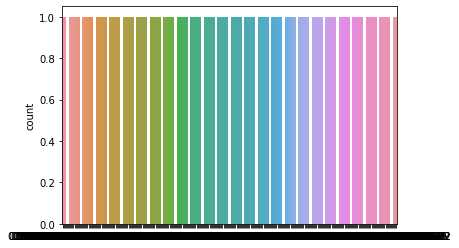

In [ ]:
sns.countplot(x=preds);

In [ ]:
# X_train = train_df
X_train = train_df.drop(columns=['Y_Class'])
X_train = pd.DataFrame(train_df['Y_Quality'])
y_train = train_df['Y_Class']

In [ ]:
X_train.isnull().sum()

Y_Quality    0
dtype: int64

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

GB_model =  GradientBoostingClassifier(random_state=37).fit(X_train, y_train)
print('Done.')

Done.


In [ ]:
test_x
# test_x = test_x.drop(columns=['LINE//','PRODUCT_CODE'])
# test_x = test_x['Y_Quality']  
test_x = pd.DataFrame(test_x, columns=['Y_Quality'])
# test_x = test_x['Y_Quality'] 

In [ ]:
test_x = pd.DataFrame(test_x)

preds = GB_model.predict(test_x)   
print('Done.')   

Done.


In [ ]:
preds

array([1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2,
       1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2,
       1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1,
       2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1,
       1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2,
       1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1,
       2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1,
       2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2,
       1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2,
       1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2,

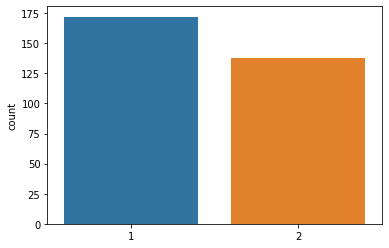

In [ ]:
sns.countplot(x=preds);

## 3.2 LGBM [0.5]

In [ ]:
from lightgbm import LGBMRegressor

LGBM_model = LGBMRegressor(random_state=37).fit(X_train, y_train) 
print('Done.') 

Done.


In [ ]:
preds=LGBM_model.predict(test_x)  
print('Done.')

Done.


In [ ]:
test_x['Y_Quality'] = preds
test_x  

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode,Y_Quality
0,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,52.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0.531415
1,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.530844
2,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.531456
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.524097
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.528226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,2.0,91.0,0.0,45.0,10.0,0.0,51.0,10.0,52.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0.527747
306,2.0,96.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.528078
307,2.0,91.0,0.0,45.0,10.0,0.0,50.0,10.0,52.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0.527309
308,2.0,95.0,0.0,45.0,10.0,0.0,51.0,10.0,52.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0.527817


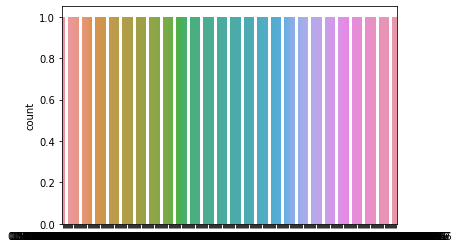

In [ ]:
sns.countplot(x=preds);

In [ ]:
# X_train = train_df
X_train = train_df.drop(columns=['Y_Class'])
X_train = pd.DataFrame(train_df['Y_Quality'])
y_train = train_df['Y_Class']

In [ ]:
X_train.isnull().sum()

Y_Quality    0
dtype: int64

In [ ]:
from lightgbm import LGBMClassifier 

LGBM_model =  LGBMClassifier(random_state=37).fit(X_train, y_train)
print('Done.')

Done.


In [ ]:
test_x
# test_x = test_x.drop(columns=['LINE//','PRODUCT_CODE'])
# test_x = test_x['Y_Quality']  
test_x = pd.DataFrame(test_x, columns=['Y_Quality'])
# test_x = test_x['Y_Quality'] 

In [ ]:
test_x = pd.DataFrame(test_x)

preds = RF.predict(test_x)   
print('Done.')   

Done.


In [ ]:
preds

array([1., 1., 1., 0., 1., 1., 2., 1., 0., 2., 1., 2., 2., 1., 0., 0., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 1., 0., 2., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 2., 1., 1., 1., 1., 1., 2.,
       1., 1., 2., 1., 2., 1., 2., 2., 1., 2., 2., 1., 1., 2., 1., 1., 1.,
       2., 1., 2., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 2., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 2., 1.,
       1., 1., 1., 1., 1.

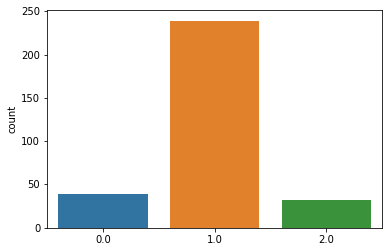

In [ ]:
sns.countplot(x=preds);

## 3.3 XGBoost [0.56]
1. fillna(0)
2. SMOTE oversampling
3. params: optuna
4. directly predict `Y_Class`

In [21]:
import xgboost as xgb
import psutil
import time 

def memory_usage(message: str = 'debug'):
    # current process RAM usage
    p = psutil.Process()
    rss = p.memory_info().rss / 2 ** 20 # Bytes to MB
    print(f"[{message}] memory usage: {rss: 10.5f} MB")


def objective(trial):

    params = {
        "objective": "multi:softprob",
        "eval_metric":'mlogloss',
        "booster": 'gbtree',
        'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'gpu_id': 0, # GPU 사용시
        # "tree_method": 'exact', 'gpu_id': -1,  # CPU 사용시
        "verbosity": 0,
        'num_class':3,
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
        'n_estimators': trial.suggest_int("n_estimators", 1000, 10000, step=100),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),     
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
        "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
        # 'num_parallel_tree': trial.suggest_int("num_parallel_tree", 1, 500) 추가하면 느려짐.
    }


    model = xgb.XGBClassifier(**params, random_state = 37, use_label_encoder = False)

    bst = model.fit(X_train, y_train,
                    eval_set=[(X_validation,y_validation)], 
                    early_stopping_rounds=50, 
                    verbose=False)
    preds = bst.predict(X_validation)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(y_validation, pred_labels)
    # f1_score = f1_score(y_validation, pred_labels)
    # print(f1_score(y_test, preds, average='macro'))
    return f1_score


if __name__ == "__main__":

    train_start = time.time()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")


    trial = study.best_trial

    print("  Accuracy: {}".format(trial.value))
    print("  Best hyperparameters: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

   
    clf = xgb.XGBClassifier(**study.best_params, random_state = 1234, use_label_encoder = False)
    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)
    # pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(y_test, preds)

    print("Accuracy: {}".format(accuracy))

    # memory_usage("학습하는데 걸린 시간  {:.2f} 분\n".format( (time.time() - train_start)/60))

[I 2023-02-21 12:31:02,652] A new study created in memory with name: no-name-b87725a7-c3f9-4336-b543-0bb13d1b38b5


  0%|          | 0/50 [00:00<?, ?it/s]

[W 2023-02-21 12:31:04,356] Trial 0 failed with parameters: {'max_depth': 8, 'learning_rate': 0.9744527889163418, 'n_estimators': 9000, 'colsample_bytree': 0.6976232878412735, 'colsample_bylevel': 0.8653572638148754, 'colsample_bynode': 0.6828791668027459, 'reg_lambda': 0.20424681542609288, 'reg_alpha': 0.07363968859366331, 'subsample': 0.95, 'min_child_weight': 2, 'gamma': 0.26920276598286536} because of the following error: The value <function f1_score at 0x7f78c3a288b0> could not be cast to float..
[W 2023-02-21 12:31:04,359] Trial 0 failed with value <function f1_score at 0x7f78c3a288b0>.
[W 2023-02-21 12:31:05,717] Trial 1 failed with parameters: {'max_depth': 5, 'learning_rate': 0.6956267332668656, 'n_estimators': 10000, 'colsample_bytree': 0.7628289025706083, 'colsample_bylevel': 0.7095354321434431, 'colsample_bynode': 0.82895394357054, 'reg_lambda': 0.7578141893503155, 'reg_alpha': 0.010727805627030643, 'subsample': 0.6, 'min_child_weight': 13, 'gamma': 0.43679149006940493} bec

ValueError: ignored

In [ ]:
# Best trial:
#   Accuracy: 1.0
#   Best hyperparameters: 
#     max_depth: 9
#     learning_rate: 0.2743942545025299
#     n_estimators: 7100
#     colsample_bytree: 0.976037633839835
#     colsample_bylevel: 0.8208068730328048
#     colsample_bynode: 0.7028939363080522
#     reg_lambda: 0.12197001975058792
#     reg_alpha: 0.5492373681818031
#     subsample: 0.8
#     min_child_weight: 11
#     gamma: 0.38692872540988676

In [24]:
clf = xgb.XGBClassifier( max_depth= 9,
    learning_rate= 0.2743942545025299,
    n_estimators= 7100,
    colsample_bytree= 0.976037633839835,
    colsample_bylevel= 0.8208068730328048,
    colsample_bynode= 0.7028939363080522,
    reg_lambda=0.12197001975058792,
    reg_alpha= 0.5492373681818031,
    subsample= 0.8,
    min_child_weight= 11,
    gamma= 0.38692872540988676,
    random_state = 37, use_label_encoder = False)
clf.fit(X_train, y_train)

preds = clf.predict(X_test)
# pred_labels = np.rint(preds)
accuracy = sklearn.metrics.accuracy_score(y_test, preds)

print("Accuracy: {}".format(accuracy))

Accuracy: 0.9291553133514986


In [26]:
preds = clf.predict(test_x)

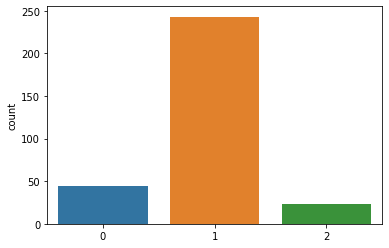

In [29]:
sns.countplot(x=preds)

In [ ]:
from xgboost import XGBRegressor

XGB_model = XGBRegressor(random_state=37).fit(X_train, y_train) 
print('Done.') 

[12:12:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done.


In [ ]:
preds=XGB_model.predict(test_x)  
print('Done.')

Done.


In [ ]:
test_x['Y_Quality'] = preds
test_x  

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode,Y_Quality
0,2.000000,94.00000,0.0,45.0,10.000000,0.0,51.000000,10.000000,52.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,7,0.524482
1,2.000000,93.00000,0.0,45.0,11.000000,0.0,45.000000,10.000000,31.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,5,0.527027
2,2.000000,95.00000,0.0,45.0,11.000000,0.0,45.000000,10.000000,31.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,5,0.528316
3,4.337449,94.44856,0.0,45.0,10.271605,0.0,48.485597,10.012346,42.407407,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,0,0.524518
4,4.337449,94.44856,0.0,45.0,10.271605,0.0,48.485597,10.012346,42.407407,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,1,0.525997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,2.000000,91.00000,0.0,45.0,10.000000,0.0,51.000000,10.000000,52.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,7,0.523075
306,2.000000,96.00000,0.0,45.0,11.000000,0.0,45.000000,10.000000,31.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,5,0.522320
307,2.000000,91.00000,0.0,45.0,10.000000,0.0,50.000000,10.000000,52.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,7,0.523158
308,2.000000,95.00000,0.0,45.0,10.000000,0.0,51.000000,10.000000,52.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,7,0.521964


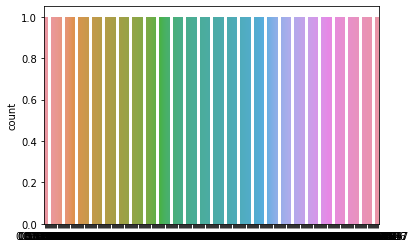

In [ ]:
sns.countplot(x=preds);

In [ ]:
# X_train = train_df
X_train = train_df.drop(columns=['Y_Class'])
X_train = pd.DataFrame(train_df['Y_Quality'])
y_train = train_df['Y_Class']

In [ ]:
X_train.isnull().sum()

Y_Quality    0
dtype: int64

In [ ]:
from xgboost import XGBClassifier

XGB_model =  XGBClassifier(random_state=37).fit(X_train, y_train)
print('Done.')

Done.


In [ ]:
test_x
# test_x = test_x.drop(columns=['LINE//','PRODUCT_CODE'])
# test_x = test_x['Y_Quality']  
test_x = pd.DataFrame(test_x, columns=['Y_Quality'])
# test_x = test_x['Y_Quality'] 

In [ ]:
test_x = pd.DataFrame(test_x)

preds = RF.predict(test_x)   
print('Done.')   

Done.


In [ ]:
preds

array([0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 2., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 1., 0., 2., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

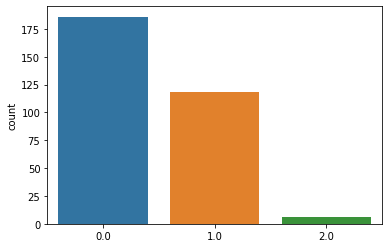

In [ ]:
sns.countplot(x=preds);

## 3.4 RandomForest
- Output: class 0 too small

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RF_model = RandomForestRegressor(random_state=37).fit(X_train, y_train) 
print('Done.') 

Done.


In [ ]:
preds=RF_model.predict(test_x)  
print('Done.')

Done.


In [ ]:
test_x['Y_Quality'] = preds
test_x  

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,line_pcode,Y_Quality
0,2.000000,94.00000,0.0,45.0,10.000000,0.0,51.000000,10.000000,52.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,7,0.533170
1,2.000000,93.00000,0.0,45.0,11.000000,0.0,45.000000,10.000000,31.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,5,0.535017
2,2.000000,95.00000,0.0,45.0,11.000000,0.0,45.000000,10.000000,31.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,5,0.534964
3,4.337449,94.44856,0.0,45.0,10.271605,0.0,48.485597,10.012346,42.407407,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,0,0.532341
4,4.337449,94.44856,0.0,45.0,10.271605,0.0,48.485597,10.012346,42.407407,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,1,0.532555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,2.000000,91.00000,0.0,45.0,10.000000,0.0,51.000000,10.000000,52.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,7,0.532656
306,2.000000,96.00000,0.0,45.0,11.000000,0.0,45.000000,10.000000,31.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,5,0.532410
307,2.000000,91.00000,0.0,45.0,10.000000,0.0,50.000000,10.000000,52.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,7,0.532898
308,2.000000,95.00000,0.0,45.0,10.000000,0.0,51.000000,10.000000,52.000000,2.0,...,49.994412,54.202353,63.806176,0.974359,247.988889,251.888889,243.3,228.844444,7,0.532914


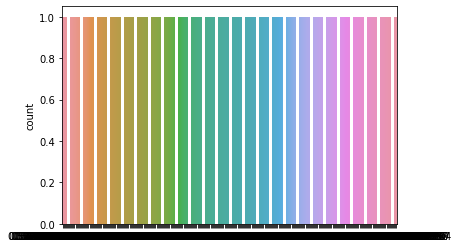

In [ ]:
sns.countplot(x=preds);

In [ ]:
# X_train = train_df
X_train = train_df.drop(columns=['Y_Class'])
X_train = pd.DataFrame(train_df['Y_Quality'])
y_train = train_df['Y_Class']

In [ ]:
X_train.isnull().sum()

Y_Quality    0
dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF_model =  RandomForestClassifier(random_state=37).fit(X_train, y_train)
print('Done.')

Done.


In [ ]:
test_x
# test_x = test_x.drop(columns=['LINE//','PRODUCT_CODE'])
# test_x = test_x['Y_Quality']  
test_x = pd.DataFrame(test_x, columns=['Y_Quality'])
# test_x = test_x['Y_Quality'] 

In [ ]:
test_x = pd.DataFrame(test_x)

preds = RF.predict(test_x)   
print('Done.')   

Done.


In [ ]:
preds

array([1., 2., 2., 1., 1., 1., 2., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 2.,
       1., 0., 1., 0., 1., 2., 1., 2., 2., 1., 2., 1., 2., 1., 2., 1., 2.,
       1., 1., 1., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
       1., 2., 1., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 2., 1., 2., 2., 1., 2., 1., 1., 1., 1., 1., 2.,
       1., 1., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 2., 1., 1., 1.,
       2., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

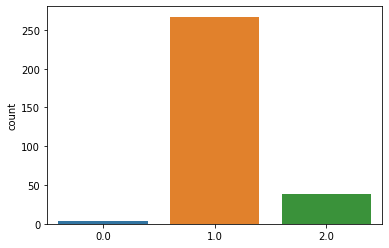

In [ ]:
sns.countplot(x=preds);

# 3-1.DL_models

## 3.1 TabNet

In [ ]:
train_x = train_df.drop(columns=['Y_Class'], axis=1)
train_y = train_df[['Y_Class']]
test_x = test_df
if "Set" not in train_df.columns:
    train_df["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(train_df.shape[0],))

train_indices = train_x[train_df.Set=="train"].index
valid_indices = train_x[train_df.Set=="valid"].index


nunique = train_df.nunique()
types = train_df.dtypes

categorical_columns = []
categorical_dims =  {}
for col in tqdm(train_x.columns):   
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train_x[col].nunique())
        l_enc = LabelEncoder()
        train_x[col] = train_x[col].fillna("NaN")
        train_x[col] = l_enc.fit_transform(train_x[col].values)
        try:
            test_x[col] = test_x[col].fillna("NaN")
            test_x[col] = l_enc.transform(test_x[col].values)
        except:
            print(f"Column {col} does not exist in test set")
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        training_mean = train_x.loc[train_indices, col].mean()
        train_df.fillna(training_mean, inplace=True)
        test_df.fillna(training_mean, inplace=True)

features = [ col for col in train_x.columns] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

X_train = train_x[features].values[train_indices]
y_train = train_y.values[train_indices]

X_valid = train_x[features].values[valid_indices]
y_valid = train_y.values[valid_indices]

X_test = test_x.values



  0%|          | 0/2878 [00:00<?, ?it/s]

X_1 11
Column X_1 does not exist in test set
X_2 17
Column X_2 does not exist in test set
X_3 1
X_4 2
Column X_4 does not exist in test set
X_5 3
Column X_5 does not exist in test set
X_6 1
X_7 14
Column X_7 does not exist in test set
X_8 3
Column X_8 does not exist in test set
X_9 3
Column X_9 does not exist in test set
X_10 2
Column X_10 does not exist in test set
X_12 179
Column X_12 does not exist in test set
X_13 170
Column X_13 does not exist in test set
X_14 1
X_15 2
Column X_15 does not exist in test set
X_16 5
Column X_16 does not exist in test set
X_17 9
Column X_17 does not exist in test set
X_18 6
Column X_18 does not exist in test set
X_19 2
Column X_19 does not exist in test set
X_20 68
Column X_20 does not exist in test set
X_21 73
Column X_21 does not exist in test set
X_22 67
Column X_22 does not exist in test set
X_23 2
Column X_23 does not exist in test set
X_24 3
Column X_24 does not exist in test set
X_25 2
Column X_25 does not exist in test set
X_26 2
Column X_26 

In [ ]:
clf = TabNetClassifier(n_steps=1, 
                       cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=1,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax', # sparsemax 
                       lambda_sparse=0)

TypeError: ignored

In [ ]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

TypeError: ignored

In [ ]:
TabNetClassifier

tabnet.tabnet.TabNetClassifier

In [ ]:
categorical_columns = train_df['line_pcode']
categorical_dims =  {}

unused_feat = ['Set']

features = [ col for col in train_df.columns] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [ ]:
# Network parameters
max_epochs = 20 if not os.getenv("CI", False) else 2
batch_size = 1024
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=1,
                       optimizer_fn=torch.optim.Adam, # Any optimizer works here
                       optimizer_params=dict(lr=2e-2),
                       scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
                       scheduler_params={"is_batch_level":True,
                                         "max_lr":5e-2,
                                         "steps_per_epoch":int(train_df.shape[0] / batch_size)+1,
                                         "epochs":max_epochs
                                          },
                       mask_type='entmax', # "sparsemax",
                      )

TypeError: ignored

In [ ]:
def my_loss_fn(y_pred, y_true):
    """
    Dummy example similar to using default torch.nn.functional.cross_entropy
    """
    softmax_pred = torch.nn.Softmax(dim=-1)(y_pred)
    logloss = (1-y_true)*torch.log(softmax_pred[:,0])
    logloss += y_true*torch.log(softmax_pred[:,1])
    return -torch.mean(logloss)

In [ ]:
class my_metric(Metric):
    """
    2xAUC.
    """

    def __init__(self):
        self._name = "custom" # write an understandable name here
        self._maximize = True

    def __call__(self, y_true, y_score):
        """
        Compute AUC of predictions.

        Parameters
        ----------
        y_true: np.ndarray
            Target matrix or vector
        y_score: np.ndarray
            Score matrix or vector

        Returns
        -------
            float
            AUC of predictions vs targets.
        """
        return 2*roc_auc_score(y_true, y_score[:, 1])

In [ ]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'val'],
    eval_metric=["auc", my_metric],
    max_epochs=max_epochs , patience=0,
    batch_size=batch_size,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    loss_fn=my_loss_fn)   



No early stopping will be performed, last training weights will be used.


KeyError: ignored

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])
# preds = clf.predict(X_test)


Device used : cpu


KeyError: ignored

# 4.Model Comparison

## 4.1 Ensemble
1. [K-fold CV + stacking Ensemble](https://www.kaggle.com/code/crownsando/kakr-4th-seminar-model-validation-ensemble)

2. [VotingClassifier](https://dacon.io/competitions/official/236035/codeshare/7430?page=1&dtype=recent)

# 5.Inference
- finally, performs perdiction for test set

In [ ]:
# test_x.describe()

In [ ]:
# preds = RF_model.predict(test_x)
# print('Done.')

In [ ]:
# test_x['Y_Class']=preds
# preds

# 6.Submit

In [30]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')  

submit['Y_Class'] = preds 
submit.to_csv('smartFactory_submission.csv', index=False)  

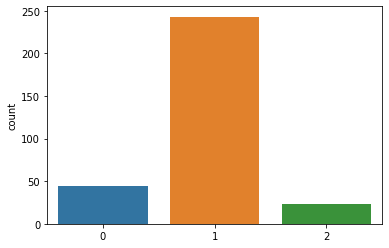

In [31]:
sns.countplot(x=preds, order=[0,1,2]);

# THE END
